In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from wordcloud import WordCloud
import tkinter as tk
from tkinter import simpledialog

In [2]:
# Load the data
data = pd.read_csv('SMSSpamCollection', sep='\t', header=None, names=['label', 'message'])

# Preprocess the data
data['label'] = data['label'].map({'ham': 0, 'spam': 1})

C:\Users\gopuk\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


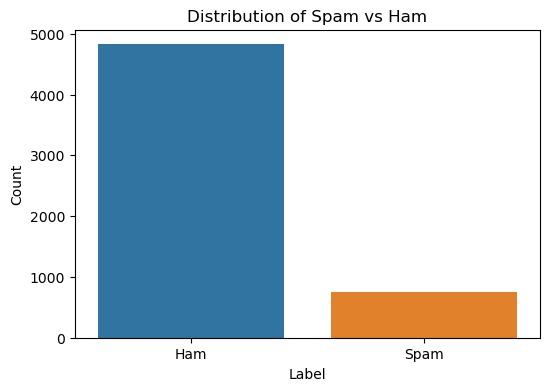

In [7]:
# Exploratory Data Analysis (EDA)
# Plot the distribution of spam vs ham
plt.figure(figsize=(6,4))
sns.countplot(data['label'])
plt.title('Distribution of Spam vs Ham')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Ham', 'Spam'])
plt.show()

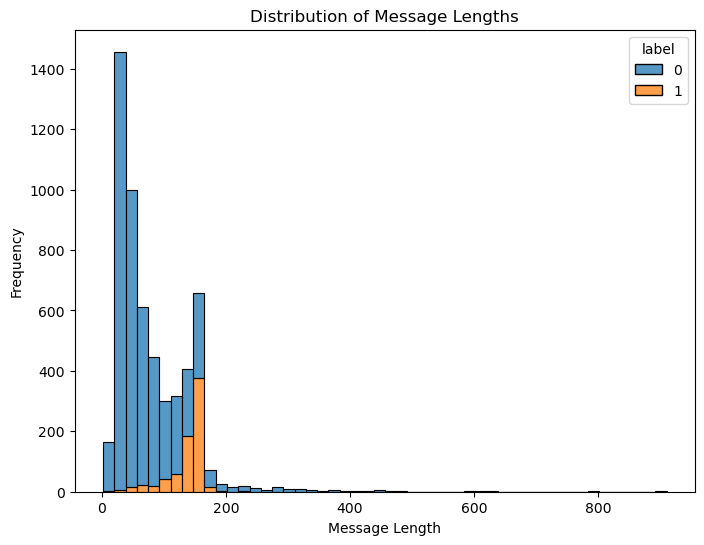

In [8]:
# Check the length of messages
data['message_length'] = data['message'].apply(len)

# Plot the distribution of message lengths
plt.figure(figsize=(8,6))
sns.histplot(data, x='message_length', hue='label', multiple='stack', bins=50)
plt.title('Distribution of Message Lengths')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.show()

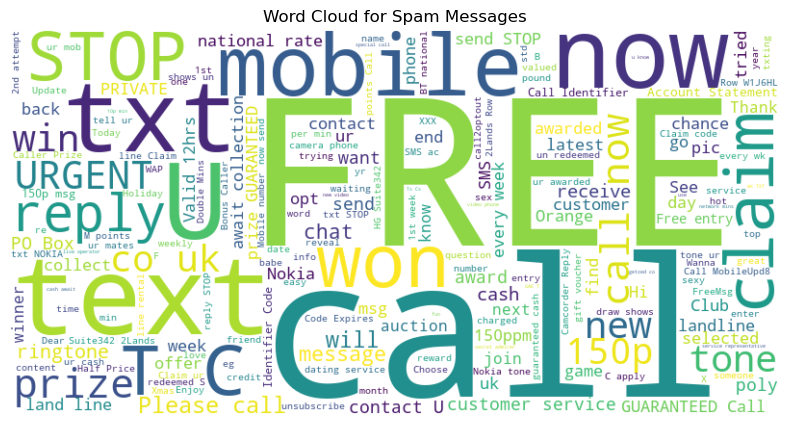

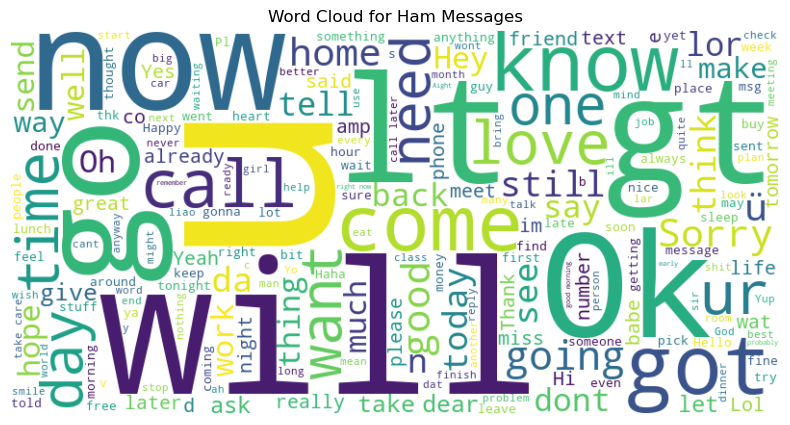

In [9]:
# Generate word clouds for spam and ham messages
spam_words = ' '.join(list(data[data['label'] == 1]['message']))
ham_words = ' '.join(list(data[data['label'] == 0]['message']))

spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_words)
ham_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(ham_words)

# Plot the word cloud for spam messages
plt.figure(figsize=(10, 5))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Spam Messages')
plt.show()

# Plot the word cloud for ham messages
plt.figure(figsize=(10, 5))
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Ham Messages')
plt.show()

In [10]:
# Feature Engineering
data['num_words'] = data['message'].apply(lambda x: len(x.split()))
data['num_special_chars'] = data['message'].apply(lambda x: sum(not c.isalnum() for c in x))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['message'], data['label'], test_size=0.2, random_state=42)

# Feature extraction using TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train a Naive Bayes classifier
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# Make predictions with Naive Bayes
nb_y_pred = nb_model.predict(X_test_tfidf)

# Train a Logistic Regression classifier
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)

# Make predictions with Logistic Regression
lr_y_pred = lr_model.predict(X_test_tfidf)

In [11]:
# Evaluate the models
nb_accuracy = accuracy_score(y_test, nb_y_pred)
lr_accuracy = accuracy_score(y_test, lr_y_pred)

print(f'Naive Bayes Accuracy: {nb_accuracy}')
print(f'Logistic Regression Accuracy: {lr_accuracy}')

print('Naive Bayes Classification Report:\n', classification_report(y_test, nb_y_pred))
print('Logistic Regression Classification Report:\n', classification_report(y_test, lr_y_pred))

Naive Bayes Accuracy: 0.9668161434977578
Logistic Regression Accuracy: 0.9766816143497757
Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       966
           1       1.00      0.75      0.86       149

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.96      1115

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       966
           1       1.00      0.83      0.90       149

    accuracy                           0.98      1115
   macro avg       0.99      0.91      0.95      1115
weighted avg       0.98      0.98      0.98      1115



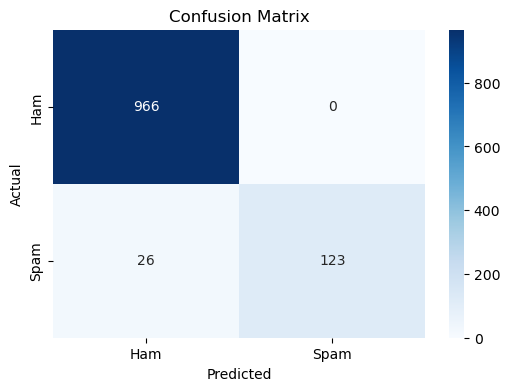

In [12]:
# Plot the confusion matrix for the best model
best_model = nb_model if nb_accuracy > lr_accuracy else lr_model
y_pred = nb_y_pred if nb_accuracy > lr_accuracy else lr_y_pred

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Hyperparameter Tuning for Logistic Regression
param_grid = {'C': [0.1, 1, 10, 100]}
grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5)
grid_search.fit(X_train_tfidf, y_train)
print(f'Best Parameters for Logistic Regression: {grid_search.best_params_}')

# Load the trained model and vectorizer
import joblib
joblib.dump(best_model, 'best_model.pkl')
joblib.dump(vectorizer, 'vectorizer.pkl')

# Function to predict if a message is spam or not
def predict_message(message):
    model = joblib.load('best_model.pkl')
    vectorizer = joblib.load('vectorizer.pkl')
    message_tfidf = vectorizer.transform([message])
    prediction = model.predict(message_tfidf)[0]
    return 'Spam' if prediction == 1 else 'Ham'

# Sample messages for prediction
sample_messages = [
    "Congratulations! You've won a free ticket to the Bahamas!",
    "Can we meet for lunch tomorrow?",
    "Get free entry to the concert by clicking this link."
]

# Display sample messages and their predictions
for msg in sample_messages:
    print(f'Message: {msg} \nPrediction: {predict_message(msg)}\n')

# Allow user to input their own messages and get the prediction
while True:
    root = tk.Tk()
    root.withdraw()  # Hide the main window
    user_input = simpledialog.askstring("Input", "Enter a message to check if it is spam:")
    if user_input:
        print(f'Message: {user_input} \nPrediction: {predict_message(user_input)}\n')
    else:
        break

Best Parameters for Logistic Regression: {'C': 100}
Message: Congratulations! You've won a free ticket to the Bahamas! 
Prediction: Ham

Message: Can we meet for lunch tomorrow? 
Prediction: Ham

Message: Get free entry to the concert by clicking this link. 
Prediction: Ham

Message: XXXMobileMovieClub: To use your credit, click the WAP link in the next txt message or click here>> http://wap. xxxmobilemovieclub.com?n=QJKGIGHJJGCBL 
Prediction: Spam

